In [17]:
import numpy as np
import matplotlib.pyplot as plt

from time import sleep

import qcodes
from qcodes.instrument_drivers.stanford_research.SR865 import SR865
from qcodes.instrument_drivers.yokogawa.GS200 import GS200

import pysweep
from pysweep import Measurement, sweep

In [2]:
sr = SR865("sr", "GPIB0::4::INSTR")

Connected to: Stanford_Research_Systems SR860 (serial:003101, firmware:V1.47) in 0.11s


In [3]:
yo = GS200("yo", "USB0::0x0B21::0x0039::91T926459::INSTR")

Connected to: YOKOGAWA GS210 (serial:91T926459, firmware:2.02) in 0.01s


In [4]:
station = qcodes.Station(sr, yo)

C:\Users\Administrator\Documents\development\qcodes_dev\qcodes\instrument\parameter.py:532: UserWarning: set_validator is deprected use `inst.vals = MyValidator` instead
  "set_validator is deprected use `inst.vals = MyValidator` instead")


In [5]:
pysweep.Measurement.set_station(station)

In [42]:
def setup_yo(station, namespace): 
    station.yo.auto_range(True)
    station.yo.output("on")
    station.yo.voltage(0.0)
    return {}

def setup_sr(station, namespace): 
    station.sr.buffer.capture_config("X")
    station.sr.buffer.start_capture("ONE", "SAMP")
    return {}
    
def cleanup_yo(station, namespace): 
    station.yo.output("off")
    return {}

def stop_capture(station, namespace): 
    station.sr.buffer.stop_capture()
    return {}

def send_trigger(station, namespace, count): 
    station.yo.voltage(5.0)
    sleep(0.01)
    station.yo.voltage(0.0)
    return {"trigger": {"unit": "-", "value": count, "independent_parameter": True}}

In [43]:
def measurement_function(station, namespace):
    
    nsamples = 100
    total_size_in_kb = int(np.ceil(nsamples * 4 / 1024))
    
    data = station.sr.visa_handle.query_binary_values(
        "CAPTUREGET? 0,{}".format(total_size_in_kb),
        datatype='f', 
        is_big_endian=False
    )
    
    return {"measurement": {"unit": "V", "value":data[:nsamples]}}

In [44]:
measurement = Measurement(
    [setup_yo, setup_sr], 
    cleanup_yo, 
    [
        sweep(send_trigger, range(100)),
        stop_capture,
        measurement_function
    ]
)

In [45]:
Measurement.use_storage("json")
data = measurement.run()

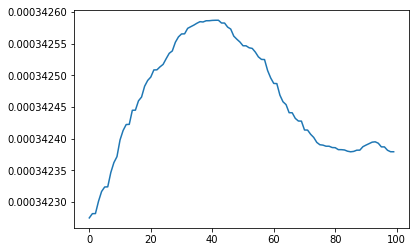

In [48]:
d = data.output("measurement")["measurement"]["value"]
t = data.output("trigger")["trigger"]["value"]

plt.plot(t, d)
plt.show()

In [52]:
Measurement.use_storage("spyview")

measurement = Measurement(
    [setup_yo, setup_sr], 
    cleanup_yo, 
    [
        sweep(send_trigger, range(100)),
        stop_capture,
        measurement_function
    ]
)

data = measurement.run(delayed_parameters=["measurement"])

In [53]:
data.output_files()

('C:\\Users\\Administrator\\data\\2017-11-22\\2017-11-22_001.dat',
 'C:\\Users\\Administrator\\data\\2017-11-22\\2017-11-22_001.meta.txt')